In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
# from tqdm import tqdm

import tensorflow as tf
from keras.models import load_model
import keras.backend as K
import keras
from scipy.stats import norm
import tensorflow as tf
import matplotlib.animation as animation
from sklearn import metrics 
import matplotlib.patheffects as PathEffects
from sklearn.decomposition import PCA
from numpy.linalg import svd
from imutils import paths

import pandas as pd
import random
from sklearn.manifold import TSNE
import glob
from scipy import misc
import scipy.stats as st
from scipy.stats import wasserstein_distance
from scipy.stats import mannwhitneyu
import sklearn
import tensorflow as tf
# from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import filters
from keras.models import Sequential, Model
from keras.applications.vgg19 import VGG19
from functools import partial
from scipy.linalg import sqrtm
from functools import partial
from random import shuffle
from keras.layers import Dense, Conv1D, Conv2D, Conv3D, Conv2DTranspose, Embedding
from keras import initializers
from keras.layers import Input, Dense
from matplotlib.patches import Rectangle
# import tensorflow_addons as tfa

2024-06-12 11:52:23.913354: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 11:52:25.220772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
domain_path = '/home/odedrot/DISCOVERenv2/ALTZHEIMER_MRI/'


In [2]:
from keras.src.saving import serialization_lib
serialization_lib.enable_unsafe_deserialization()

In [3]:
from platform import python_version
print(python_version())
print(tf.__version__)
print(keras.__version__)
tf.config.list_physical_devices('GPU')

3.12.2
2.16.1
3.1.1


2024-06-12 11:52:29.308810: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-12 11:52:29.330762: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[]

In [7]:
img_size = 64
nmax = 5000

In [8]:
def sample_images(imgs, r,c):
    
    if r==1:
        fig, axs = plt.subplots(r, c, figsize=(20,2*r))
        cnt = 0
        for j in range(c):
            axs[j].imshow(imgs[cnt, :,:,0], cmap='gray')
            axs[j].axis('off')
            cnt += 1
        plt.show()
    else:
        fig, axs = plt.subplots(r, c, figsize=(20,2*r))
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
    
def sample_images_labels(imgs, labels, r, c):
    fig, axs = plt.subplots(r, c, figsize=(20,2*r))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            axs[i,j].set_title(str(labels[cnt]), fontsize=20) # str(cnt) + ' - ' + 
            cnt += 1
    plt.show()

In [20]:
# load data
margin=20
def load_images(directory):
    imagePaths = list(paths.list_images(directory))
    data = []
    images_name = []
    i = 1
    for imagePath in imagePaths:
        images_name.append(imagePath.split("/")[-1])
        image = cv2.imread(imagePath) # load the image
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # swap color channels
        image = image[margin:image.shape[0]-margin , margin:image.shape[1]-margin] 
        image = cv2.resize(image, (img_size,img_size)) 
        data.append(image)
        i = i+1
        if i>nmax:
            break
    data_arr = np.array(data)
    req_images = np.array(data)
    req_images =  np.array(req_images).astype("float32")
    req_images = np.expand_dims(req_images, axis=3)
    return req_images , images_name

################################################################################################
# test
images1, names1 = load_images(domain_path + 'data/test/NonDemented')
images0, names0 = load_images(domain_path + 'data/test/MildDemented')
images2, names2 = load_images(domain_path + 'data/test/VeryMildDemented') 
images = np.concatenate((images0, images1, images2)) 
names = np.concatenate((names0, names1, names2))


labels_1 = np.ones((images1.shape[0])) 
labels_0 = np.zeros((images0.shape[0] + images2.shape[0]))
### test data only
# images = np.concatenate((images0, images2, images1, images3)) # aa , bc
# names = np.concatenate((names0, names2, names1, names3))
# labels_aa = np.ones((images0.shape[0] + images2.shape[0])) 
# labels_bc = np.zeros((images1.shape[0] + images3.shape[0]))

true_labels = np.concatenate(( labels_1, labels_0  ))
images = images.astype("float32") / 255

print('images' , images.shape)


##################################################################################################

images (299, 64, 64, 1)


In [21]:
# https://github.com/OwalnutO/SSIM-Loss-Tensroflow/blob/master/SSIM_loss_class.py

def tf_ssim(img1, img2, k1=0.03, k2=0.003, WS=7, data_range=1):
    
    size = 7
    sigma=1.5
    x_data, y_data = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    x_data = np.expand_dims(x_data, axis=-1)
    x_data = np.expand_dims(x_data, axis=-1)
    y_data = np.expand_dims(y_data, axis=-1)
    y_data = np.expand_dims(y_data, axis=-1)
    x = tf.constant(x_data, dtype=tf.float32)
    y = tf.constant(y_data, dtype=tf.float32)
    g = tf.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    window = g / tf.reduce_sum(g)
    
    (_, _, _, channel) = img1.shape# .as_list()
    window = tf.tile(window, [1, 1, channel, 1])
    mu1 = tf.nn.depthwise_conv2d(img1, window, strides = [1, 1, 1, 1], padding = 'SAME')
    mu2 = tf.nn.depthwise_conv2d(img2, window, strides = [1, 1, 1, 1], padding = 'SAME')
    mu1_sq = mu1 * mu1
    mu2_sq = mu2 * mu2
    mu1_mu2 = mu1 * mu2
    img1_2 = img1*img1 #tf.pad(img1*img1, [[0,0], [0, WS//2], [0, WS//2], [0,0]], "CONSTANT")
    sigma1_sq = tf.subtract(tf.nn.depthwise_conv2d(img1_2, window, strides = [1 ,1, 1, 1], padding = 'SAME') , mu1_sq)
    img2_2 = img2*img2 #tf.pad(img2*img2, [[0,0], [0, WS//2], [0, WS//2], [0,0]], "CONSTANT")
    sigma2_sq = tf.subtract(tf.nn.depthwise_conv2d(img2_2, window, strides = [1, 1, 1, 1], padding = 'SAME') ,mu2_sq)
    img12_2 = img1*img2 #tf.pad(img1*img2, [[0,0], [0, WS//2], [0, WS//2], [0,0]], "CONSTANT")
    sigma1_2 = tf.subtract(tf.nn.depthwise_conv2d(img12_2, window, strides = [1, 1, 1, 1], padding = 'SAME') , mu1_mu2)
    c1 = (k1*data_range)**2
    c2 = (k2*data_range)**2
    ssim_map = ((2*mu1_mu2 + c1)*(2*sigma1_2 + c2)) / ((mu1_sq + mu2_sq + c1)*(sigma1_sq + sigma2_sq + c2))
    
    return ssim_map

# https://nmarkou.blogspot.com/2020/10/gaussian-filter-in-keras-code-snippet.html
# https://stackoverflow.com/questions/55643675/how-do-i-implement-gaussian-blurring-layer-in-keras

def _gaussian_kernel(kernlen=[21, 21], nsig=[3, 3]):
        assert len(nsig) == 2
        assert len(kernlen) == 2
        kern1d = []
        for i in range(2):
            interval = (2 * nsig[i] + 1.) / (kernlen[i])
            x = np.linspace(-nsig[i] - interval / 2., nsig[i] + interval / 2.,
                            kernlen[i] + 1)
            kern1d.append(np.diff(st.norm.cdf(x)))

        kernel_raw = np.sqrt(np.outer(kern1d[0], kern1d[1]))
        # divide by sum so they all add up to 1
        kernel = kernel_raw / kernel_raw.sum()
        return kernel

# Initialise to set kernel to required value
def kernel_init(shape, dtype):
    kernel = np.zeros(shape)
    kernel[:, :, 0, 0] = _gaussian_kernel([shape[0], shape[1]])
    return kernel
    
def gaussian_filter_block(input_layer,
                          kernel_size=3,
                          strides=(1, 1),
                          dilation_rate=(1, 1),
                          padding="same",
                          activation=None,
                          trainable=False,
                          use_bias=False):

    return keras.layers.DepthwiseConv2D(
        kernel_size=kernel_size,
        strides=strides,
        padding=padding,
        depth_multiplier=1,
        dilation_rate=dilation_rate,
        activation=activation,
        use_bias=use_bias,
        trainable=trainable,
        depthwise_initializer=kernel_init,
        kernel_initializer=kernel_init)(input_layer)

# @tf.keras.utils.register_keras_serializable(package='Custom', name='Wvar_reg')
def Wvar_reg(weight_matrix):
    return tf.math.reduce_mean(tf.math.variance(weight_matrix))

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 308ms/step


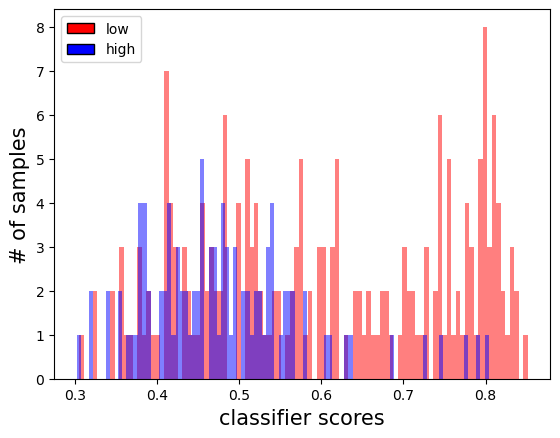

medians diff   -0.13164741


In [22]:
saved_name = 'vgg_seed_3_epoch_64_auc_0.75_gmax_0.73_tpr_0.69_tnr_0.78_acc_0.73_f1_0.72.keras'   
clf_model_path = domain_path + 'saved_CLF/' + saved_name
clf_model = load_model(clf_model_path , compile=True)

images3D = images.repeat(3, -1)   
images3D_clfscore = clf_model.predict(images3D)

scores_label0 = images3D_clfscore[true_labels==0]
scores_label1 = images3D_clfscore[true_labels==1]
_ = plt.hist(scores_label0 , 100, alpha = 0.5, color= 'r')
_ = plt.hist(scores_label1 , 100, alpha = 0.5, color= 'b')
# plt.title('Quality scores based on real images', fontsize=20)
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ["red", "blue"] ]
labels= ["low", "high"]
plt.legend(handles, labels)
plt.xlabel("classifier scores", fontsize=15)
plt.ylabel("# of samples", fontsize=15)
plt.show()

print( 'medians diff  ' , np.median(scores_label1) - np.median(scores_label0) )

In [23]:
# load models
@tf.function
def gray2rgb(tensor):
    tensor = tf.image.grayscale_to_rgb(tensor)
    return tensor

models_path = domain_path + 'saved_DISCOVER_MODEL/' # <---------------1

latent_dim = 350
# ae_model = tf.keras.models.load_model(ae_model_path , compile=False, safe_mode=False, custom_objects={"gray2rgb": gray2rgb})  #
encoder = tf.keras.models.load_model(models_path + 'encoder_epoch_1_perc_3.457_CLF_2.411_zcr_0.1276_disent_acc_5.858_disent_loss_0.0_cov_loss_0.99988.keras') 
decoder = tf.keras.models.load_model(models_path + 'generator_epoch_1_perc_3.457_CLF_2.411_zcr_0.1276_disent_acc_5.858_disent_loss_0.0_cov_loss_0.99988.keras') 
recognizer = tf.keras.models.load_model(models_path + 'recognizer_epoch_1_perc_3.457_CLF_2.411_zcr_0.1276_disent_acc_5.858_disent_loss_0.0_cov_loss_0.99988.keras') 
discriminator1D = tf.keras.models.load_model(models_path + 'discriminator1D_epoch_1_perc_3.457_CLF_2.411_zcr_0.1276_disent_acc_5.858_disent_loss_0.0_cov_loss_0.99988.keras') 

/home/odedrot/.conda/envs/DISCOVERenv2/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [24]:
# encode/decode images
try:
    z_dist, Escore = encoder.predict(images)
except:
    z_dist = encoder.predict(images) 
    

images_recon = decoder.predict(z_dist)
print(z_dist.shape)
latent_dim = z_dist.shape[1]

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step
(299, 350)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 293ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 294ms/step


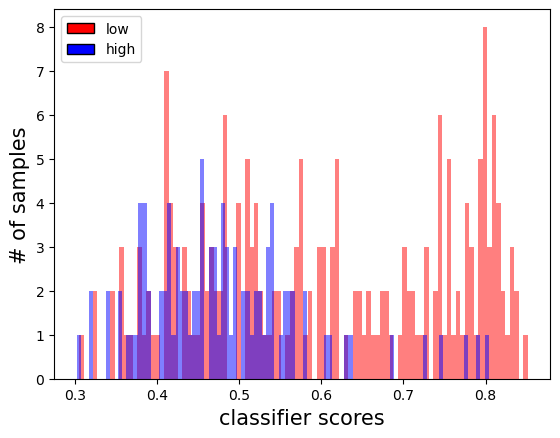

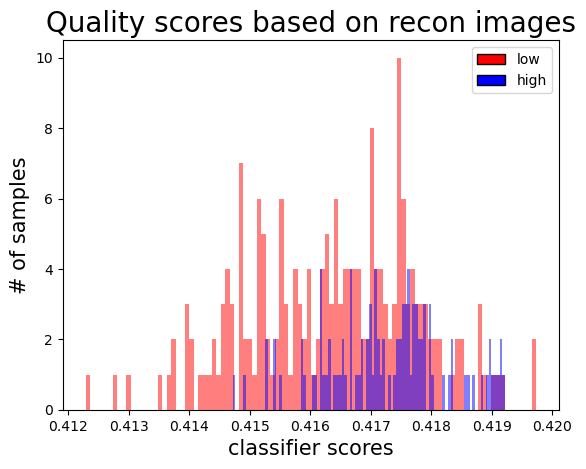

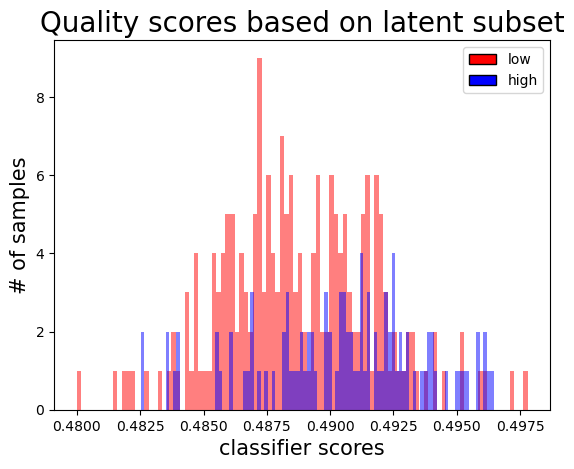

/tmp/ipykernel_95936/2699301299.py:48: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(images3D_clfscore, images_recon3D_clfscore, c=cols, s=5, cmap='gray')


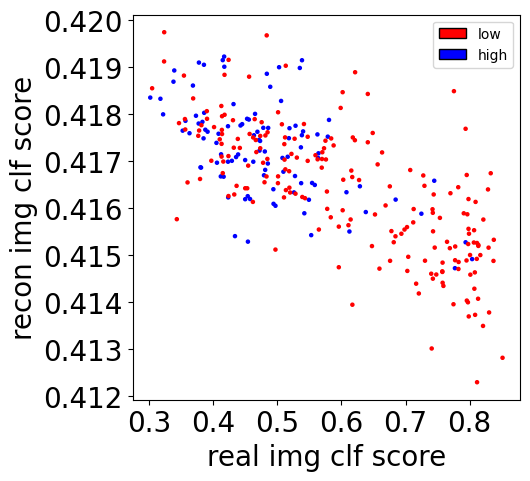

/tmp/ipykernel_95936/2699301299.py:59: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(images3D_clfscore, Escore, c=cols, s=5, cmap='gray')


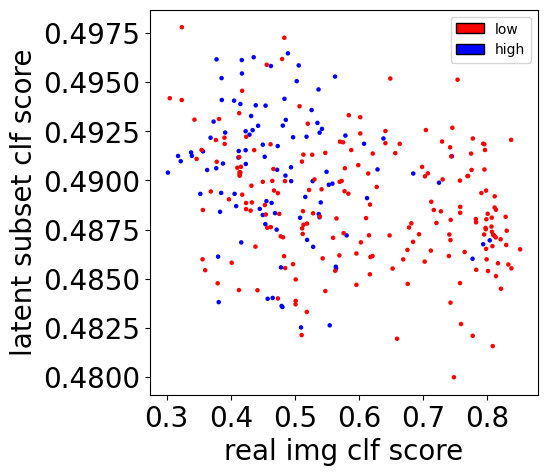

auc GT_labels vs real  0.2645728643216081
auc GT_labels vs recon 0.6924623115577889
auc GT_labels vs z_score 0.6603768844221106
mae(clf(x), clf(xrecon))  0.16253737
mae(clf(x), clf(z_score))  0.13141593


In [25]:
# real vs recon clf scores

images3D = images.repeat(3, -1)   
images3D_clfscore = clf_model.predict(images3D)

images_recon3D = images_recon.repeat(3, -1)   
images_recon3D_clfscore = clf_model.predict(images_recon3D)
###############################################
_ = plt.hist(images3D_clfscore[true_labels==0] , 100, alpha = 0.5, color= 'r')
_ = plt.hist(images3D_clfscore[true_labels==1] , 100, alpha = 0.5, color= 'b')
# plt.title('Quality scores based on real images', fontsize=20)
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ["red", "blue"] ]
labels= ["low", "high"]
plt.legend(handles, labels)
plt.xlabel("classifier scores", fontsize=15)
plt.ylabel("# of samples", fontsize=15)
plt.show()

_ = plt.hist(images_recon3D_clfscore[true_labels==0] , 100, alpha = 0.5, color= 'r')
_ = plt.hist(images_recon3D_clfscore[true_labels==1] , 100, alpha = 0.5, color= 'b')
plt.title('Quality scores based on recon images', fontsize=20)
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ["red", "blue"] ]
labels= ["low", "high"]
plt.legend(handles, labels)
plt.xlabel("classifier scores", fontsize=15)
plt.ylabel("# of samples", fontsize=15)
plt.show()

_ = plt.hist(Escore[true_labels==0] , 100, alpha = 0.5, color= 'r')
_ = plt.hist(Escore[true_labels==1] , 100, alpha = 0.5, color= 'b')
plt.title('Quality scores based on latent subset', fontsize=20)
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ["red", "blue"] ]
labels= ["low", "high"]
plt.legend(handles, labels)
plt.xlabel("classifier scores", fontsize=15)
plt.ylabel("# of samples", fontsize=15)
plt.show()

###############################################

cols=[]
for l in true_labels:
    if l==0:
        cols.append('red')
    elif l==1:
        cols.append('blue')
plt.figure(figsize=(5,5))
plt.scatter(images3D_clfscore, images_recon3D_clfscore, c=cols, s=5, cmap='gray')
plt.xlabel("real img clf score", fontsize=20)
plt.ylabel("recon img clf score", fontsize=20)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ["red", "blue"] ]
labels= ["low", "high"]
plt.legend(handles, labels)
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(images3D_clfscore, Escore, c=cols, s=5, cmap='gray')
plt.xlabel("real img clf score", fontsize=20)
plt.ylabel("latent subset clf score", fontsize=20)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ["red", "blue"] ]
labels= ["low", "high"]
plt.legend(handles, labels)
plt.show()


# calculate auc for real and recon imgs vs true labels (drop not aa or bb bc cb cc)

true_labels_0_1 = []
images3D_clfscore_0_1 = []
images_recon3D_clfscore_0_1 = []
Escore_0_1 = []
for i in range(len(true_labels)):
    if true_labels[i] == 0 or true_labels[i] == 1:
        true_labels_0_1.append(true_labels[i]) 
        images3D_clfscore_0_1.append(images3D_clfscore[i])
        images_recon3D_clfscore_0_1.append(images_recon3D_clfscore[i])
        Escore_0_1.append(Escore[i])

fpr, tpr, thresholds = metrics.roc_curve(true_labels_0_1, images3D_clfscore_0_1)
print('auc GT_labels vs real ' , metrics.auc(fpr, tpr))
recon_fpr, recon_tpr, recon_thresholds = metrics.roc_curve(true_labels_0_1, images_recon3D_clfscore_0_1)
print('auc GT_labels vs recon' ,metrics.auc(recon_fpr, recon_tpr))
recon_fpr, recon_tpr, recon_thresholds = metrics.roc_curve(true_labels_0_1, Escore_0_1)
print('auc GT_labels vs z_score' ,metrics.auc(recon_fpr, recon_tpr))
###############################################
# mae 
print('mae(clf(x), clf(xrecon)) ' , np.mean(np.abs(images3D_clfscore - images_recon3D_clfscore )) )
print('mae(clf(x), clf(z_score)) ' , np.mean(np.abs(images3D_clfscore - Escore )) )